<a href="https://colab.research.google.com/github/bi-horn/ML_Heart_Disease/blob/main/Heart_disease_data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart disease prediction - supervised learning algorithms

In [1]:
#Mount Google Drive
from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
drive.mount('/content/drive')

Mounted at /content/drive


### Load libraries and data

In [2]:
import pandas as pd
import numpy as np
import yaml # für Konfigurationen

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

from sklearn.impute import KNNImputer
from sklearn.feature_selection import chi2
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from prettytable import PrettyTable

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set()

In [3]:
#load helper functions if necessary
%run '/content/drive/My Drive/Colab Notebooks/utils.ipynb'

In [4]:
# Importing data
data_path = '/content/drive/My Drive/heart_disease/data/cardiovascular_risk.csv'

df = pd.read_csv(data_path,index_col='id')

### Data exploration

In [5]:
# First 5 rows of the dataset
print(df.head())
print(df.shape) # 16 columns, 3390 entries

    age  education sex is_smoking  cigsPerDay  BPMeds  prevalentStroke  \
id                                                                       
0    64        2.0   F        YES         3.0     0.0                0   
1    36        4.0   M         NO         0.0     0.0                0   
2    46        1.0   F        YES        10.0     0.0                0   
3    50        1.0   M        YES        20.0     0.0                0   
4    64        1.0   F        YES        30.0     0.0                0   

    prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
id                                                                             
0              0         0    221.0  148.0   85.0    NaN       90.0     80.0   
1              1         0    212.0  168.0   98.0  29.77       72.0     75.0   
2              0         0    250.0  116.0   71.0  20.35       88.0     94.0   
3              1         0    233.0  158.0   88.0  28.26       68.0     94.0   
4

In [ ]:
#explore variable types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3390 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              3390 non-null   int64  
 1   education        3303 non-null   float64
 2   sex              3390 non-null   object 
 3   is_smoking       3390 non-null   object 
 4   cigsPerDay       3368 non-null   float64
 5   BPMeds           3346 non-null   float64
 6   prevalentStroke  3390 non-null   int64  
 7   prevalentHyp     3390 non-null   int64  
 8   diabetes         3390 non-null   int64  
 9   totChol          3352 non-null   float64
 10  sysBP            3390 non-null   float64
 11  diaBP            3390 non-null   float64
 12  BMI              3376 non-null   float64
 13  heartRate        3389 non-null   float64
 14  glucose          3086 non-null   float64
 15  TenYearCHD       3390 non-null   int64  
dtypes: float64(9), int64(5), object(2)
memory usage: 450.2+ KB


### Variable names

##### Sex: binary (male or female)
##### Age: Age of the patient (Continuous in years)
##### Education: The level of education(categorical values - 1,2,3,4)

##### is_smoking: current smoker "YES" or "NO")
##### Cigs Per Day: average # if cigarettes/day (continuous)

##### BP Meds: on blood pressure medication (Nominal)
##### Prevalent Stroke: past stroke (Nominal)
##### Prevalent Hyp: hypertension (Nominal)
##### Diabetes: diabetes (Nominal)

##### Tot Chol: total cholesterol level (Continuous)
##### Sys BP: systolic blood pressure (Continuous)
##### Dia BP: diastolic blood pressure (Continuous)
##### BMI: Body Mass Index (Continuous)
##### Heart Rate: heart rate (Continuous)
##### Glucose: glucose level (Continuous)


##### Label/Prediction: 10-year risk of coronary heart disease CHD(binary: “1”, means “Yes”, “0” means “No”)


In [6]:
# Renaming the columns
df.rename(columns={'cigsPerDay':'cigs_per_day','BPMeds':'bp_meds',
                   'prevalentStroke':'prevalent_stroke','prevalentHyp':'prevalent_hyp',
                   'totChol':'total_cholesterol','sysBP':'systolic_bp','diaBP':'diastolic_bp',
                   'BMI':'bmi','heartRate':'heart_rate','TenYearCHD':'ten_year_chd'},
          inplace = True)

In [7]:
# Encoding the binary columns
df['sex'] = np.where(df['sex'] == 'M',1,0)
df['is_smoking'] = np.where(df['is_smoking'] == 'YES',1,0)
print(df.head())

    age  education  sex  is_smoking  cigs_per_day  bp_meds  prevalent_stroke  \
id                                                                             
0    64        2.0    0           1           3.0      0.0                 0   
1    36        4.0    1           0           0.0      0.0                 0   
2    46        1.0    0           1          10.0      0.0                 0   
3    50        1.0    1           1          20.0      0.0                 0   
4    64        1.0    0           1          30.0      0.0                 0   

    prevalent_hyp  diabetes  total_cholesterol  systolic_bp  diastolic_bp  \
id                                                                          
0               0         0              221.0        148.0          85.0   
1               1         0              212.0        168.0          98.0   
2               0         0              250.0        116.0          71.0   
3               1         0              233.0        

In [ ]:
# Dataset Describe
df.describe(include='all')

,age,education,sex,is_smoking,cigs_per_day,bp_meds,prevalent_stroke,prevalent_hyp,diabetes,total_cholesterol,systolic_bp,diastolic_bp,bmi,heart_rate,glucose,ten_year_chd
count,3390.000000,3303.000000,3390.000000,3390.000000,3368.000000,3346.000000,3390.000000,3390.000000,3390.000000,3352.000000,3390.00000,3390.000000,3376.000000,3389.000000,3086.000000,3390.000000
mean,49.542183,1.970936,0.432743,0.497640,9.069477,0.029886,0.006490,0.315339,0.025664,237.074284,132.60118,82.883038,25.794964,75.977279,82.086520,0.150737
std,8.592878,1.019081,0.495529,0.500068,11.879078,0.170299,0.080309,0.464719,0.158153,45.247430,22.29203,12.023581,4.115449,11.971868,24.244753,0.357846
min,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.50000,48.000000,15.960000,45.000000,40.000000,0.000000
25%,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.00000,74.500000,23.020000,68.000000,71.000000,0.000000
50%,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.50000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,56.000000,3.000000,1.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.00000,90.000000,28.040000,83.000000,87.000000,0.000000
max,70.000000,4.000000,1.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.00000,142.500000,56.800000,143.000000,394.000000,1.000000


In [8]:
#exclude all categorical variables or contonuous variables

cat_var = ['education', 'sex', 'is_smoking', 'bp_meds', 'prevalent_stroke', 'prevalent_hyp', 'diabetes', 'ten_year_chd']
cont_var = ['age', 'cigs_per_day', 'total_cholesterol', 'systolic_bp', 	'diastolic_bp', 'bmi', 'heart_rate', 'glucose']
dependent_var = ['ten_year_chd'] #label 0/1

# df with continuous variables only
df_cont = df.drop(columns=cat_var)

#df with categorical variables only
df_cat = df.drop(columns=cont_var)

## Data vizualisation

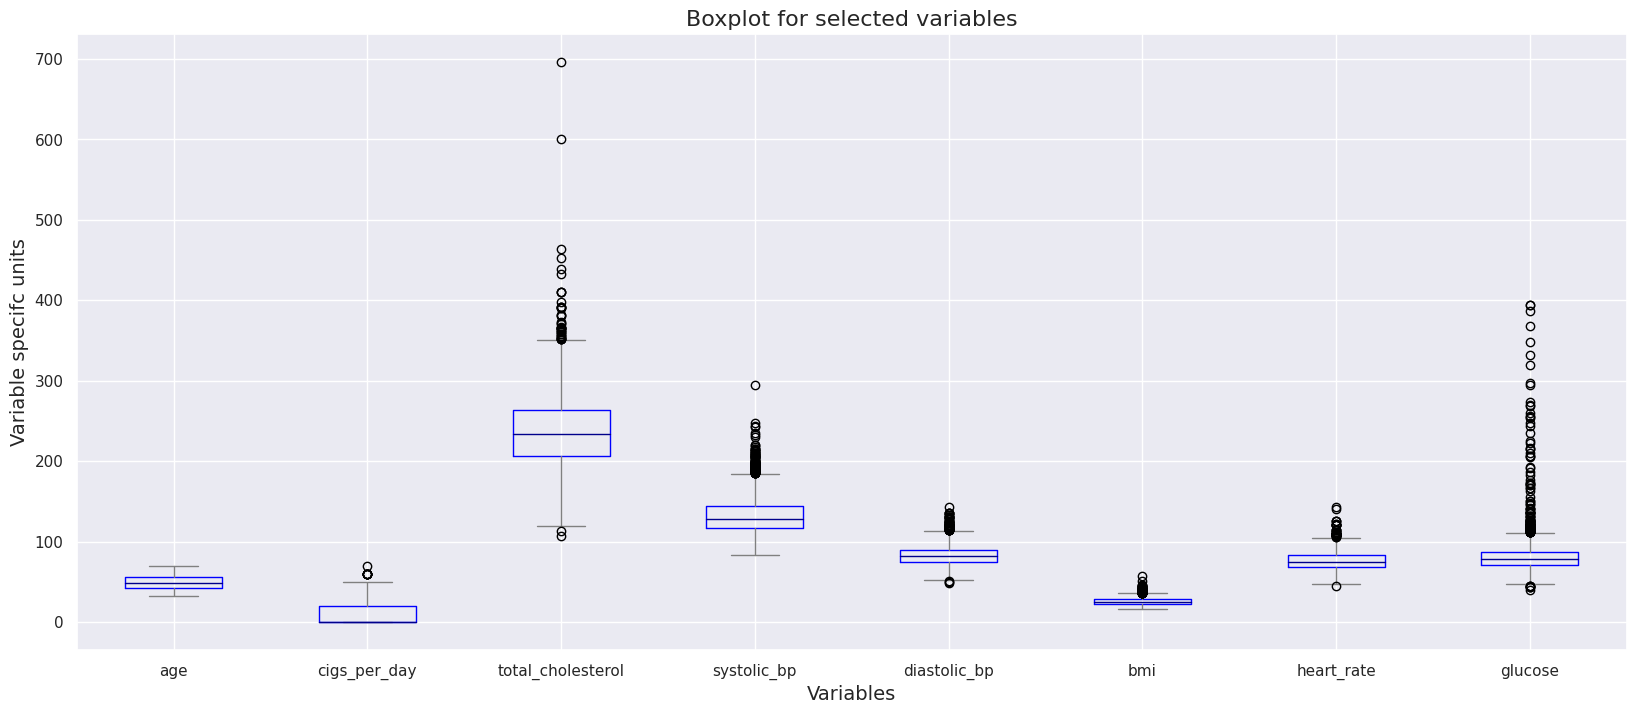

In [9]:
#Create Box plot for all continuous variables

plt.figure(figsize=(20, 8))

boxprops = dict(color='blue', linewidth=1)
medianprops = dict(color='darkblue', linewidth=1)
whiskerprops = dict(color='grey', linewidth=1)
capprops = dict(color='grey', linewidth=1)

df_cont.boxplot(
    boxprops=boxprops,
    medianprops=medianprops,
    whiskerprops=whiskerprops,
    capprops=capprops
)

# Achsenbeschriftungen
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Variable specifc units', fontsize=14)
plt.title('Boxplot for selected variables', fontsize=16)

# Gitter hinzufügen
plt.grid(True)


# Plot anzeigen
plt.show()


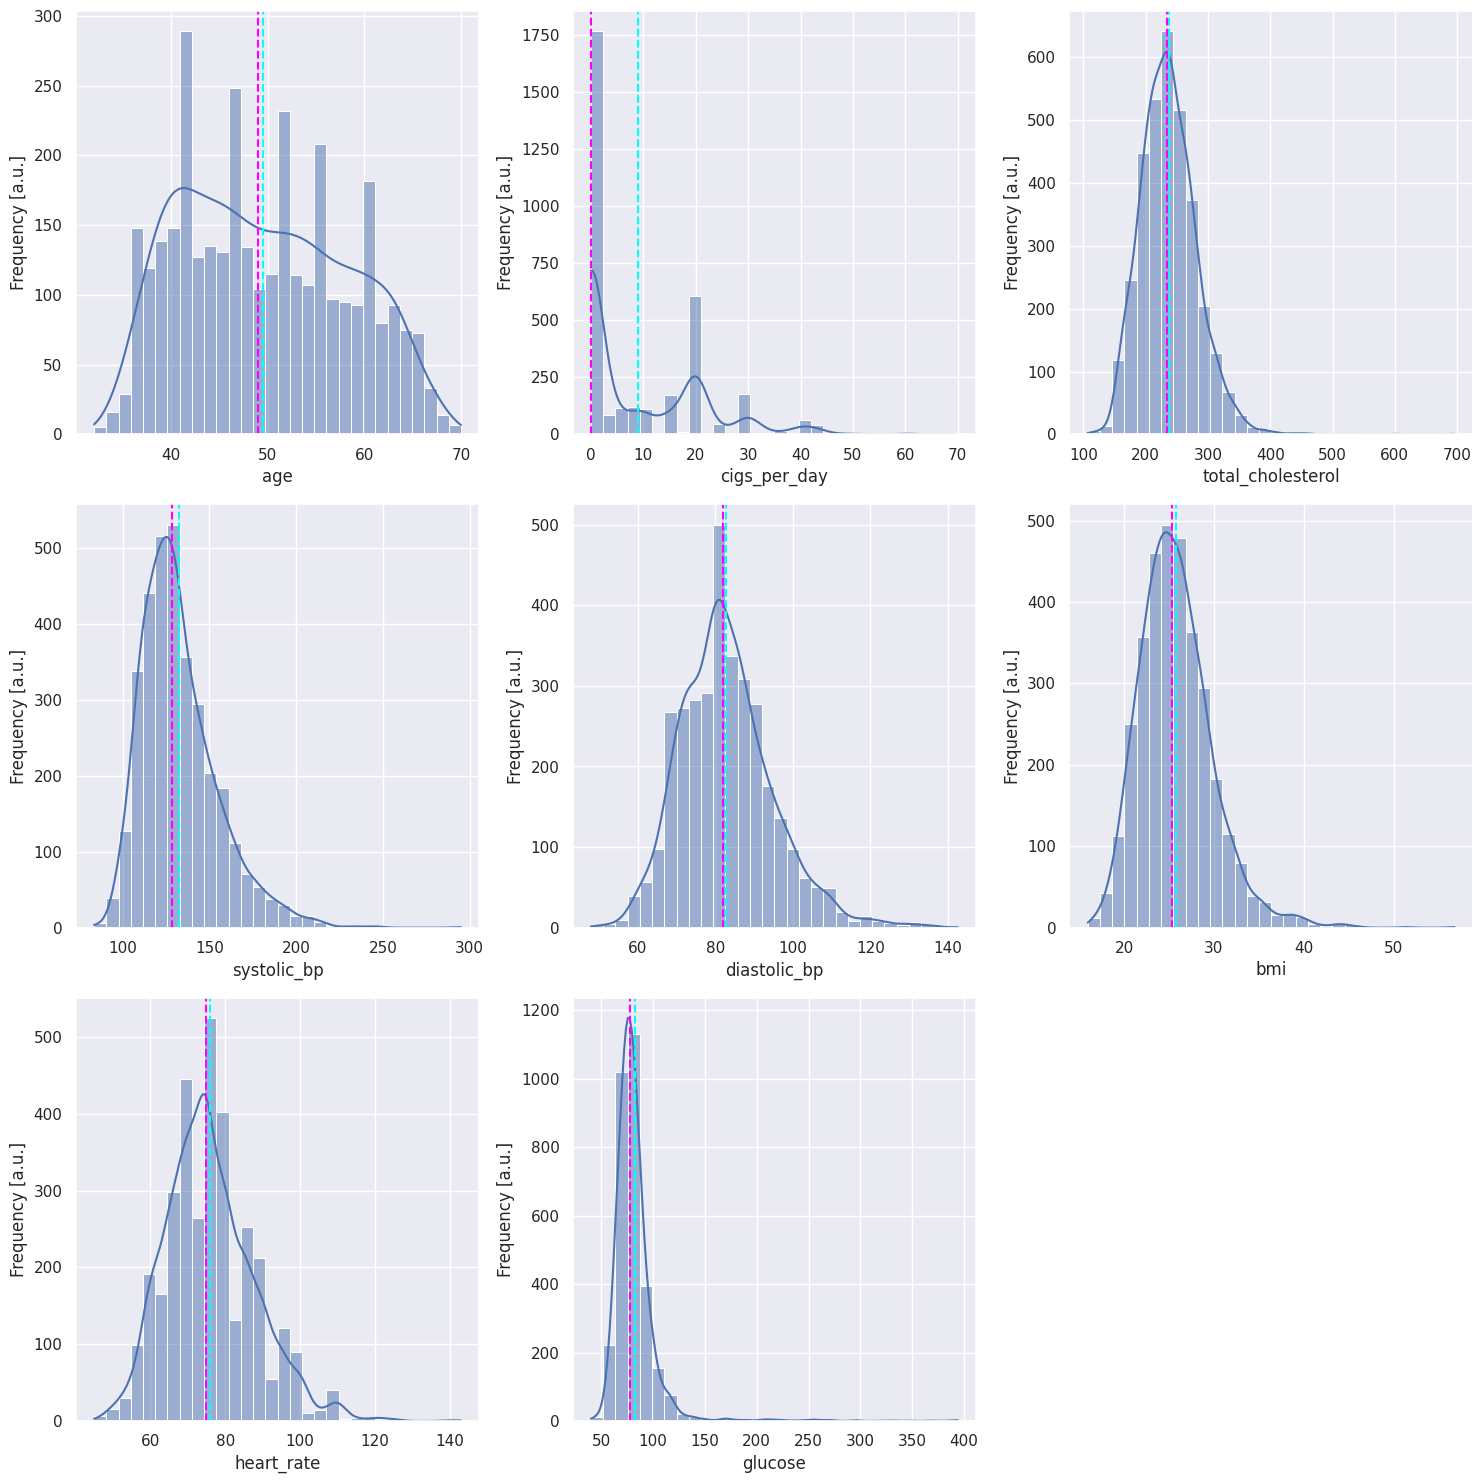

In [10]:
#Plot distributions of all continuous variables

# Calculate the number of rows and columns for subplots
num_cols = 3  # Number of columns for subplots
num_rows = (len(df_cont.columns) + num_cols - 1) // num_cols  # Number of rows needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Flatten axes if necessary (in case of single row or single column)
axes = axes.flatten()

# Loop through each column in the DataFrame
for i, column in enumerate(df_cont.columns):
    # Plot histogram for numerical columns
    sns.histplot(df_cont[column], bins=30, kde=True, ax=axes[i])
    # Add mean and median lines
    mean_val = df[column].mean()
    median_val = df[column].median()
    axes[i].axvline(mean_val, color='cyan', linestyle='--', label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='magenta', linestyle='--', label=f'Median: {median_val:.2f}')
    #axes[i].set_title(column)
    axes[i].set_xlabel(column)  # Set x-label to column name
    axes[i].set_ylabel('Frequency [a.u.]')

# Remove any extra empty subplots
for j in range(len(df_cont.columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


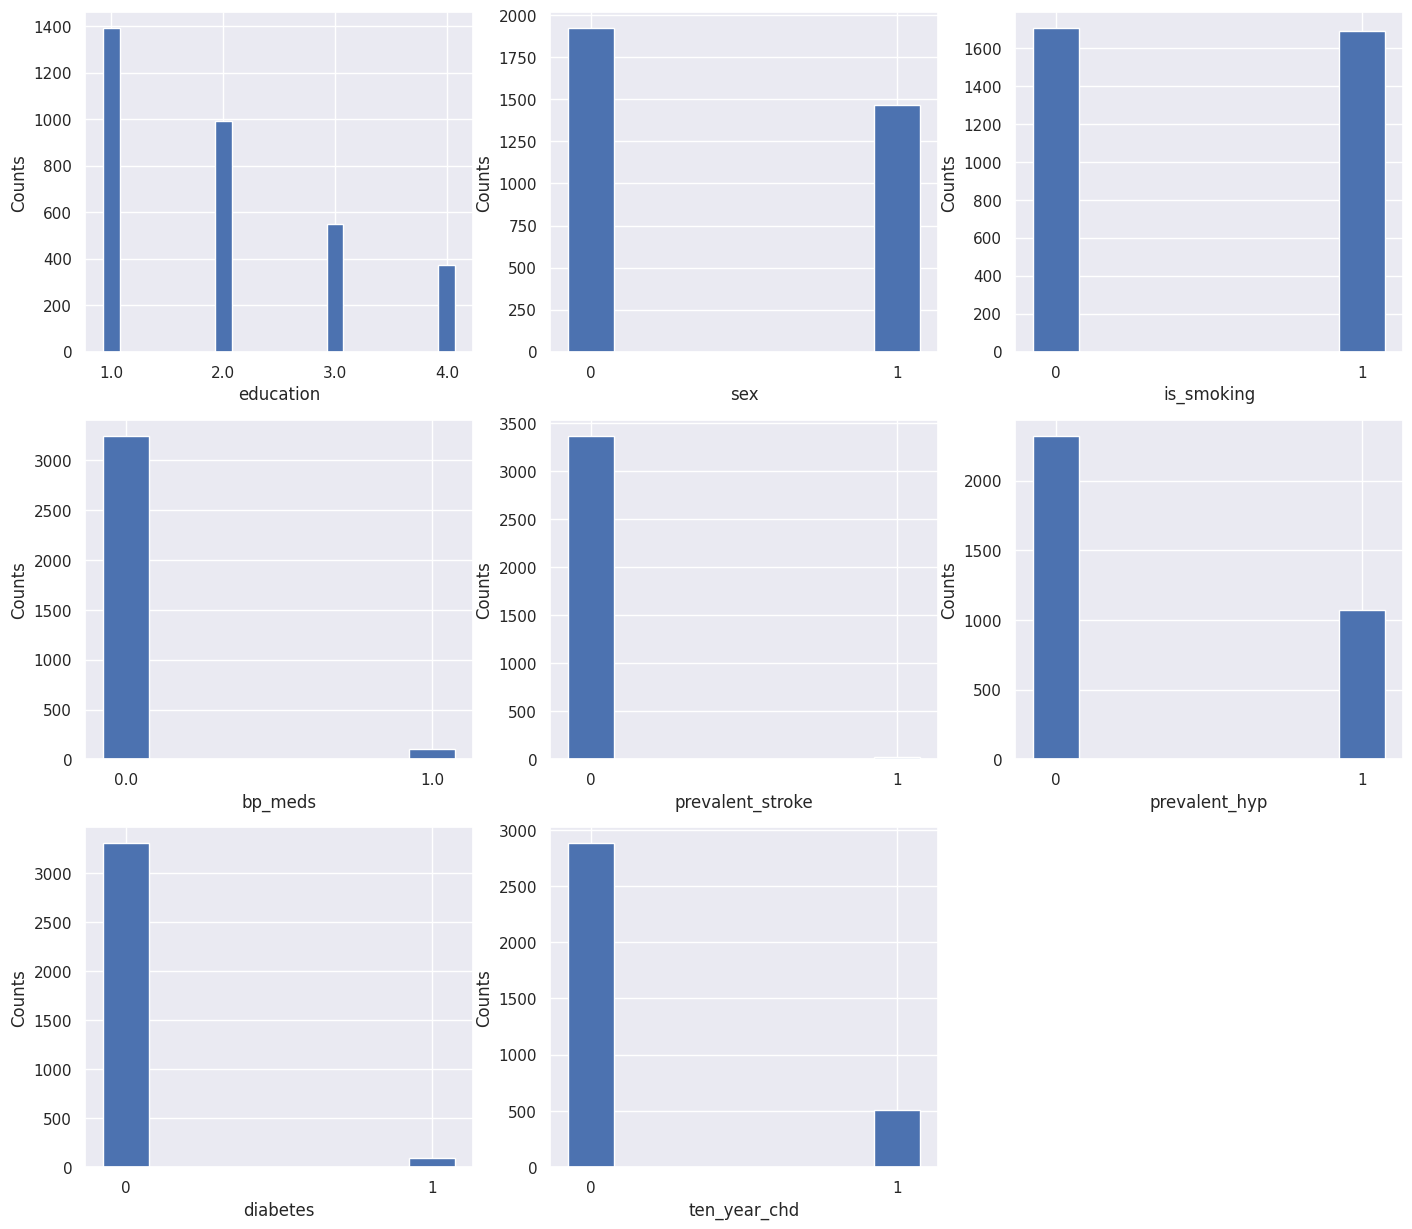

In [11]:
#Plot distributions of all categorical variables

# Calculate the number of rows and columns for subplots
num_cols = 3  # Number of columns for subplots
num_rows = (len(df_cat.columns) + num_cols - 1) // num_cols  # Number of rows needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(17, 15))

# Flatten axes if necessary (in case of single row or single column)
axes = axes.flatten()

# Loop through each column in the DataFrame
for i, column in enumerate(df_cat.columns):
  # Plot count plot for categorical columns
  # Calculate value counts for the column
  value_counts = df_cat[column].value_counts(normalize=False)
  # Create a bar plot with all categories
  axes[i].bar(range(len(value_counts)), value_counts.values, width=0.15)

  # Set ticks and labels for categories
  axes[i].set_xticks(range(len(value_counts)))
  axes[i].set_xticklabels(value_counts.index)
  axes[i].set_xlabel(column)
  axes[i].set_ylabel('Counts')

# Remove any extra empty subplots
for j in range(len(df_cat.columns), len(axes)):
    fig.delaxes(axes[j])


The dependent variable (ten year risk of CHD) is unbalanced:
2879 No Risk vs 511 Risk (15%)

In [12]:
# Distribution of dependent variable
df[dependent_var].value_counts()

ten_year_chd
0               2879
1                511
dtype: int64

### Missing data handling

##### Mode imputation - impute or fill in those missing values with some estimated values for categorical variables
##### Replace missing values with mean for continuous variables

In [ ]:
# checking null values in total
df.isna().sum().sum()

510

In [ ]:
# checking for null values in columns
df.isna().sum()

age                    0
education             87
sex                    0
is_smoking             0
cigs_per_day          22
bp_meds               44
prevalent_stroke       0
prevalent_hyp          0
diabetes               0
total_cholesterol     38
systolic_bp            0
diastolic_bp           0
bmi                   14
heart_rate             1
glucose              304
ten_year_chd           0
dtype: int64

In [ ]:
# education and bp_meds distribution before mode imputation
print(df.education.value_counts())
print(df.bp_meds.value_counts())

1.0    1391
2.0     990
3.0     549
4.0     373
Name: education, dtype: int64
0.0    3246
1.0     100
Name: bp_meds, dtype: int64


In [13]:
# Replacing the missing values in the categorical columns with the most frequent entry
df['education'] = df['education'].fillna(df['education'].mode()[0])
df['bp_meds'] = df['bp_meds'].fillna(df['bp_meds'].mode()[0])

In [ ]:
# education and bp_meds distribution after mode imputation
print(df.education.value_counts())
print(df.bp_meds.value_counts())

1.0    1478
2.0     990
3.0     549
4.0     373
Name: education, dtype: int64
0.0    3290
1.0     100
Name: bp_meds, dtype: int64


In [ ]:
# Mean and median number of cigarettes per day
df.cigs_per_day.mean().round(0),df.cigs_per_day.median()

(9.0, 0.0)

In [ ]:
# mean and median number of cigarettes per day for a smoker (excluding non-smokers)
df[df['is_smoking']==1]['cigs_per_day'].mean(),df[df['is_smoking']==1]['cigs_per_day'].median()

(18.345945945945946, 20.0)

Given that the distribution is positively skewed, median imputation is a more appropriate choice than mean imputation

In [14]:
# Calculate skewness of the 'cigs_per_day', 'total_cholesterol', 'bmi' and 'heart_rate' variable

cigs_skewness = skew(df['cigs_per_day'].dropna())
print("Skewness of 'cigs_per_day':", cigs_skewness)

cholesterol_skewness = skew(df['total_cholesterol'].dropna())
print("Skewness of 'total_cholesterol':", cholesterol_skewness)

bmi_skewness = skew(df['bmi'].dropna())
print("Skewness of 'bmi':", bmi_skewness)

heart_skewness = skew(df['heart_rate'].dropna())
print("Skewness of 'heart_rate':", heart_skewness)

Skewness of 'cigs_per_day': 1.2224606158410267
Skewness of 'total_cholesterol': 0.9402147235705626
Skewness of 'bmi': 1.0217977454297462
Skewness of 'heart_rate': 0.6761902654566112


Given that the distributions are positively skewed, median imputation is a more appropriate choice than mean imputation

In [15]:
# Imputing the missing values in the 'cigs_per_day', 'total_cholesterol', 'bmi' and 'heart_rate' with the median value
df['cigs_per_day'] = df['cigs_per_day'].fillna(df[df['is_smoking']==1]['cigs_per_day'].median())
df['total_cholesterol'] = df['total_cholesterol'].fillna(df['total_cholesterol'].median())
df['bmi'] = df['bmi'].fillna(df['bmi'].median())
df['heart_rate'] = df['heart_rate'].fillna(df['heart_rate'].median())

In [16]:
# for glucose 304 entries are missing -> number too high to just impute missing values with median

# Using KNN imputer with K=10
#for each missing value, the imputer will use the 10 nearest neighbors (in terms of other features) to estimate a value for imputation
imputer = KNNImputer(n_neighbors=10)
imputed = imputer.fit_transform(df)
df = pd.DataFrame(imputed, columns=df.columns)

In [ ]:
df.info() #imputer changes datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                3390 non-null   float64
 1   education          3390 non-null   float64
 2   sex                3390 non-null   float64
 3   is_smoking         3390 non-null   float64
 4   cigs_per_day       3390 non-null   float64
 5   bp_meds            3390 non-null   float64
 6   prevalent_stroke   3390 non-null   float64
 7   prevalent_hyp      3390 non-null   float64
 8   diabetes           3390 non-null   float64
 9   total_cholesterol  3390 non-null   float64
 10  systolic_bp        3390 non-null   float64
 11  diastolic_bp       3390 non-null   float64
 12  bmi                3390 non-null   float64
 13  heart_rate         3390 non-null   float64
 14  glucose            3390 non-null   float64
 15  ten_year_chd       3390 non-null   float64
dtypes: float64(16)
memory us

In [17]:
# changing datatypes
df = df.astype({'age': int, 'education':int,'sex':int,'is_smoking':int,'cigs_per_day':int,
               'bp_meds':int,'prevalent_stroke':int,'prevalent_hyp':int,'diabetes':int,
               'total_cholesterol':float,'systolic_bp':float,'diastolic_bp':float,
               'bmi':float,'heart_rate':float,'glucose':float,'ten_year_chd':int})

In [18]:
#exclude all categorical variables or contonuous variables

cat_var = ['education', 'sex', 'is_smoking', 'bp_meds', 'prevalent_stroke', 'prevalent_hyp', 'diabetes']
cont_var = ['age', 'cigs_per_day', 'total_cholesterol', 'systolic_bp', 	'diastolic_bp', 'bmi', 'heart_rate', 'glucose']
dependent_var = ['ten_year_chd']

# df with continuous variables only
df_cont = df.drop(columns=cat_var + dependent_var)

#df with categorical variables only
df_cat = df.drop(columns=cont_var + dependent_var)


In [19]:
#verify no missing values in these columns anymore
df.isna().sum()

age                  0
education            0
sex                  0
is_smoking           0
cigs_per_day         0
bp_meds              0
prevalent_stroke     0
prevalent_hyp        0
diabetes             0
total_cholesterol    0
systolic_bp          0
diastolic_bp         0
bmi                  0
heart_rate           0
glucose              0
ten_year_chd         0
dtype: int64

## Data Analysis for the dependent variable and the categorical variables within the dataset

#### look into Risk/No Risk ratios related to certain categorical variables

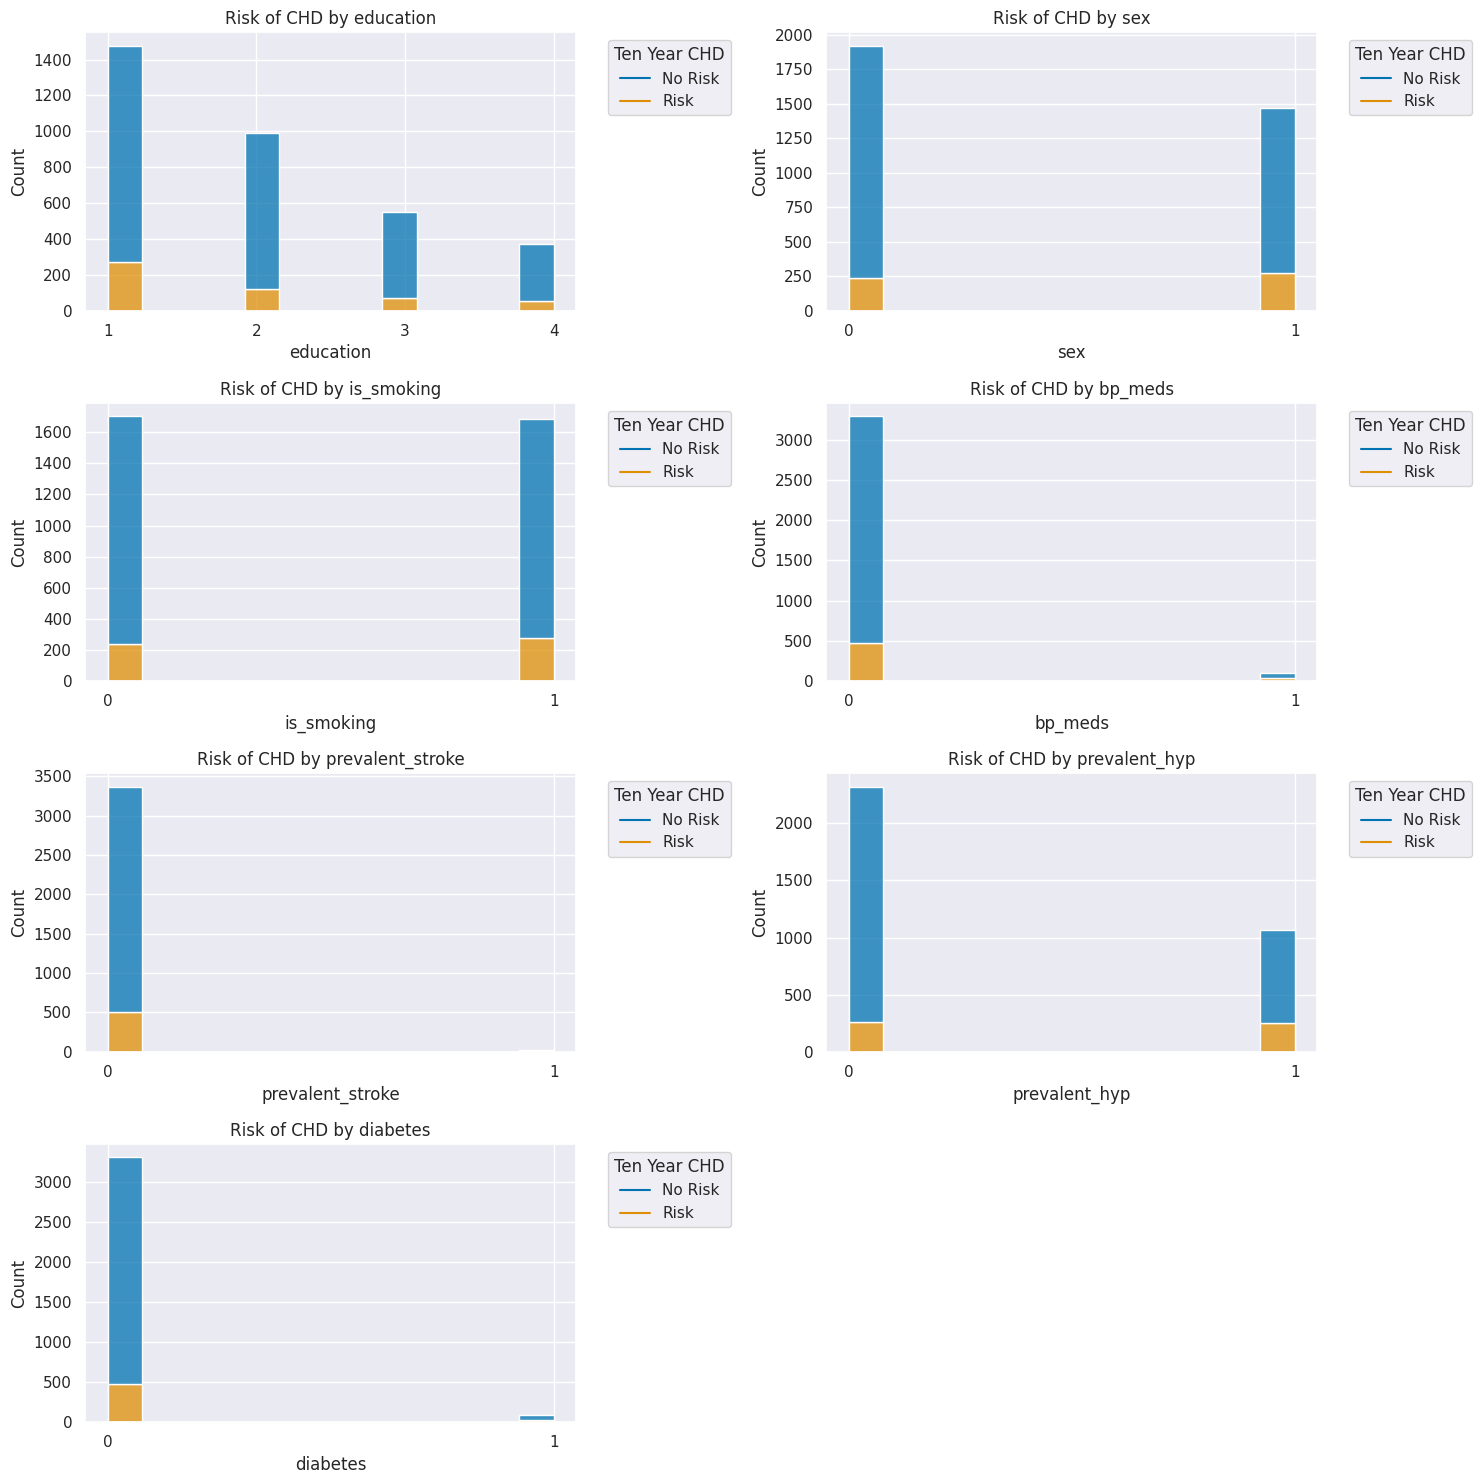

In [ ]:
# Set up subplots
num_cols = 2  # Number of columns for subplots
num_rows = (len(df_cat.columns) + num_cols - 1) // num_cols  # Number of rows needed

# Define legend labels
legend_labels = ['No Risk', 'Risk']

# Define custom colors for the plot
custom_palette = sns.color_palette("colorblind")
#custom_palette = ["magenta", "blue"]

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = axes.flatten()

# Analyzing the relationship between the dependent variable and categorical independent variables
for i, column in enumerate(df_cat.columns):
    sns.histplot(x=column, hue=dependent_var[0], data=df, stat="count", multiple="stack", ax=axes[i], palette=custom_palette, legend=False)
    axes[i].set_title(f'Risk of CHD by {column}')
    # Set only categories as x ticks
    axes[i].set_xticks(df_cat[column].unique())
    axes[i].set_xticklabels(df_cat[column].unique())

    # Create custom legend
    handles = [plt.Line2D([], [], color=custom_palette[i], label=label) for i, label in enumerate(legend_labels)]
    axes[i].legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', title='Ten Year CHD')

# Hide any unused subplots
for j in range(len(df_cat.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

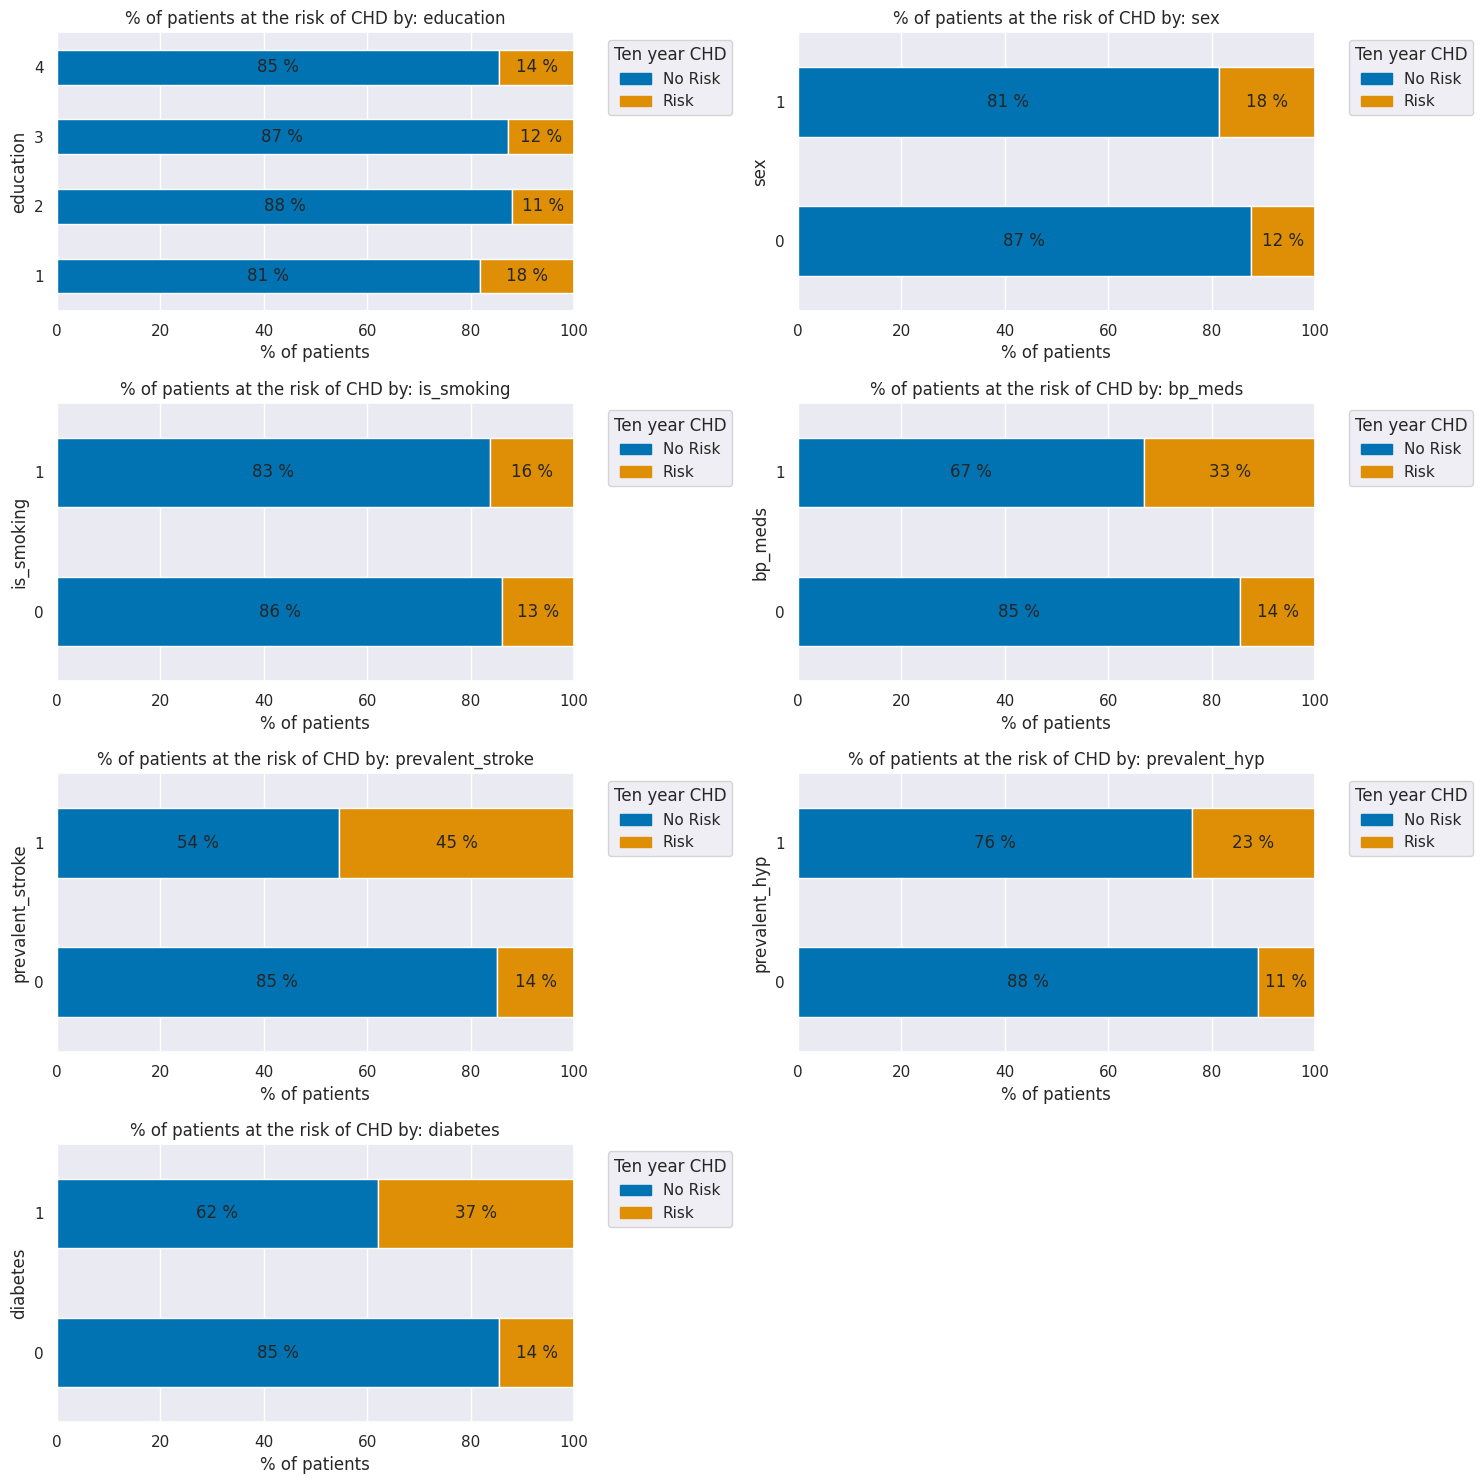

In [ ]:

# Set up subplots
num_cols = 2  # Number of columns for subplots
num_rows = (len(cat_var) + num_cols - 1) // num_cols  # Number of rows needed

# Define legend labels
legend_labels = ['No Risk', 'Risk']

# Define custom colors for the plot
custom_palette = sns.color_palette("colorblind")

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = axes.flatten()

# Generate 100% stacked bar chart for each variable in cat_var
for i, x_var in enumerate(cat_var):
    # Extract x and y variables
    y_var = dependent_var[0]

    # Group data by x_var and calculate percentages
    df_grouped = df.groupby(x_var)[y_var].value_counts(normalize=True).unstack(level=-1) * 100


    # Plot stacked bar chart
    df_grouped.plot.barh(stacked=True, ax=axes[i], color=custom_palette)

    # Set title and labels
    axes[i].set_title(f"% of patients at the risk of CHD by: {x_var}")
    axes[i].set_xlabel("% of patients")
    axes[i].set_ylabel(x_var)
    axes[i].set_xlim(0, 100)

    # Add legend
    handles = [plt.Rectangle((0,0),1,1, color=custom_palette[i], label=label) for i, label in enumerate(legend_labels)]
    axes[i].legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', title='Ten year CHD')

    # Add percentage labels
    for ix, row in df_grouped.reset_index(drop=True).iterrows():
        cumulative = 0
        for element in row:
            if element > 0.1:
                axes[i].text(cumulative + element / 2, ix, f"{int(element)} %", va="center", ha="center")
            cumulative += element

# Hide any unused subplots
for j in range(len(cat_var), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


The prevalence of Ten-Year Coronary Heart Disease (CHD) increases with prevalent stroke (45% compared to 14%), diabetes (37% compared to 14%), hypertension (23% compared to 11%), and blood pressure medication (33% compared to 14%).

## Data Analysis for the dependent variable and the continuous variables within the dataset

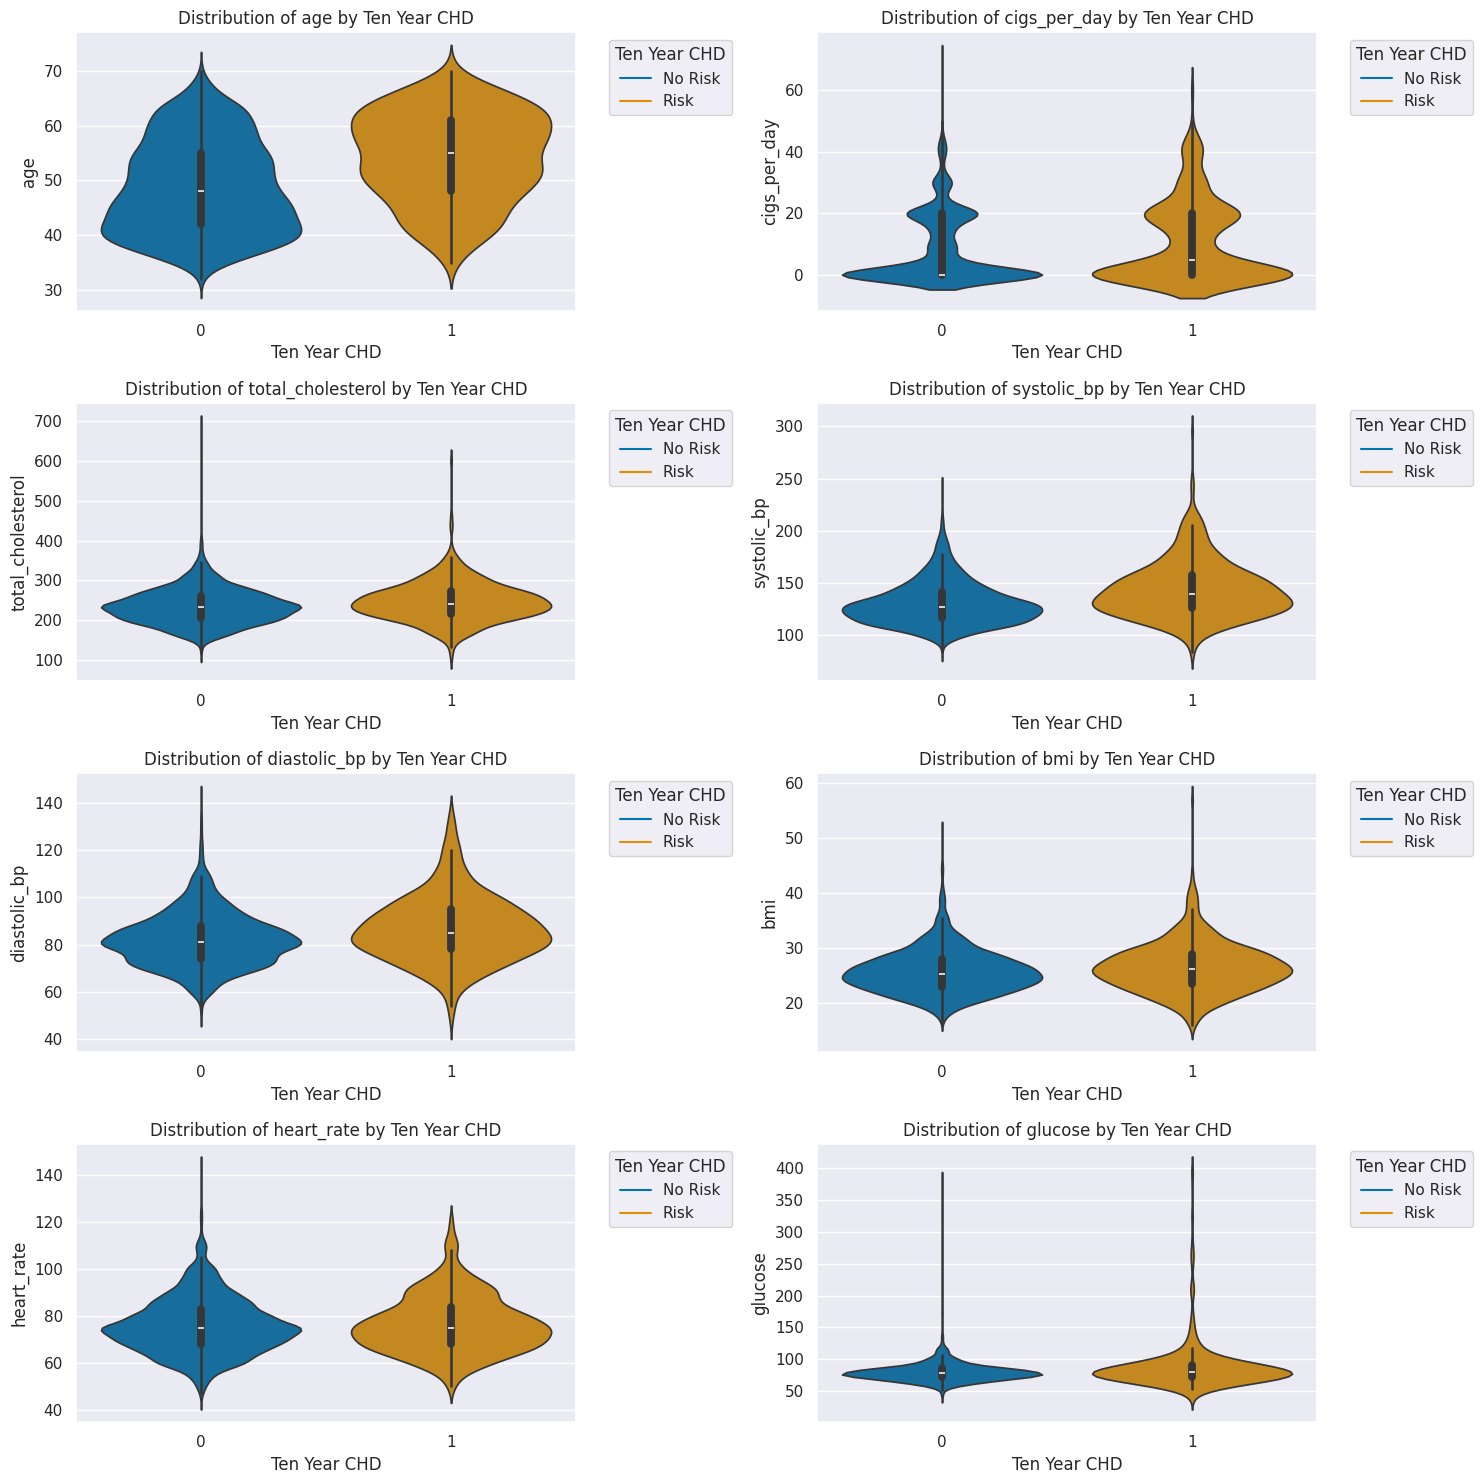

In [20]:
# Set up subplots
num_cols = 2  # Number of columns for subplots
num_rows = (len(cont_var) + num_cols - 1) // num_cols  # Number of rows needed

# Define legend labels
legend_labels = ['No Risk', 'Risk']

# Define custom colors for the plot
custom_palette = sns.color_palette("colorblind")

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = axes.flatten()

# Analyzing the relationship between the dependent variable and continuous independent variables
for i, column in enumerate(cont_var):
    sns.violinplot(x=dependent_var[0], y=column, data=df, ax=axes[i], palette=custom_palette)
    axes[i].set_title(f'Distribution of {column} by Ten Year CHD')
    axes[i].set_xlabel('Ten Year CHD')
    axes[i].set_ylabel(column)

    # Create custom legend
    handles = [plt.Line2D([], [], color=custom_palette[i], label=label) for i, label in enumerate(legend_labels)]
    axes[i].legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', title='Ten Year CHD')

# Hide any unused subplots
for j in range(len(cont_var), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Greater age, cigarette consumption per day, systolic and diastolic blodd pressure seem to correspond to a higher prevalence of Ten-Year Coronary Heart Disease (CHD). No obvious trends for other contiuous variables

## Correlation between indepedent variables - testing for collinearity

<Axes: title={'center': 'Correlation Analysis'}>

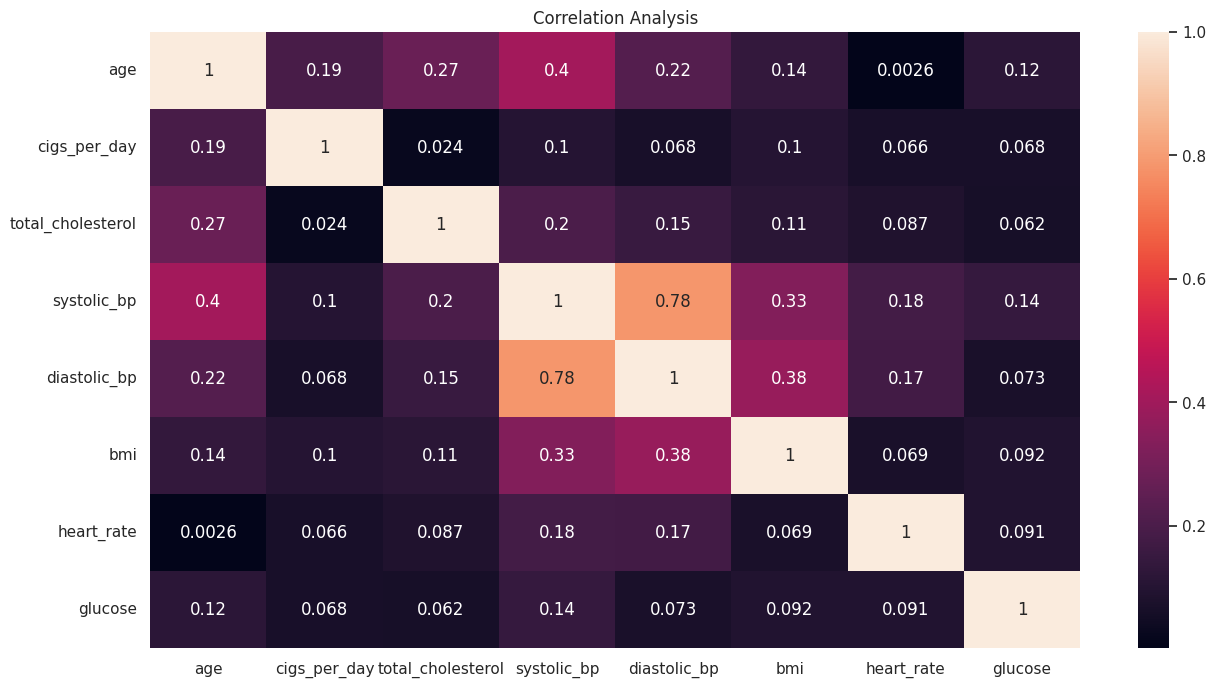

In [ ]:
# Correlation magnitude
plt.figure(figsize=(15,8))
plt.title('Correlation Analysis')
correlation = df[cont_var].corr()
sns.heatmap(abs(correlation), annot=True)#, cmap='coolwarm')


Variables systolic BP and diastolic BP are highly correlated
-> replacement of these variables with Pulse Pressure = Systolic Blood Pressure - Diastolic Blood Pressure to avoid multicollinearity

In [21]:
# Creating a new column pulse_pressure
# and dropping systolic_bp and diastolic_bp

df['pulse_pressure'] = df['systolic_bp']-df['diastolic_bp']
df.drop('systolic_bp',axis=1,inplace=True)
df.drop('diastolic_bp',axis=1,inplace=True)

In [22]:
# Updating the cont_var list and df_cont

cont_var.remove('systolic_bp')
cont_var.remove('diastolic_bp')
cont_var.append('pulse_pressure')

df_cont = df.drop(columns=cat_var + dependent_var)

## Outliers in log-transormed continuous variables

In [29]:
def outliers(df_out, drop = False):
    for each_feature in df_out.columns:
        feature_data = df_out[each_feature]
        Q1 = np.percentile(feature_data, 25.) # 25th percentile of the data of the given feature
        Q3 = np.percentile(feature_data, 75.) # 75th percentile of the data of the given feature
        IQR = Q3-Q1 #Interquartile Range
        outlier_step = IQR * 1.5 #That's we were talking about above
        outliers = feature_data[~((feature_data >= Q1 - outlier_step) & (feature_data <= Q3 + outlier_step))].index.tolist()
        print('For the feature {}, No of Outliers is {}'.format(each_feature, len(outliers)))

In [30]:
outliers(df_cont)

For the feature age, No of Outliers is 0
For the feature cigs_per_day, No of Outliers is 9
For the feature total_cholesterol, No of Outliers is 43
For the feature bmi, No of Outliers is 79
For the feature heart_rate, No of Outliers is 64
For the feature glucose, No of Outliers is 186
For the feature pulse_pressure, No of Outliers is 138


Except for age and cigs_per_day columns, rest of the numerical columns contain outliers even after log transformation.
To handle this, we can impute the outliers beyond 3 standard deviations from the mean with its median value on the train data.



## Feature selection

-Feature selection is essential in ML for improving model performance and interpretability

-The chi-square test is a common technique used for discrete feature selection

-helps to assess the relationship between categorical variables and the dependent variable

-The null hypothesis states that the variables are independent, while the alternate hypothesis suggests otherwise

-p-value greater than 0.05 indicates independence, while a lower p-value suggests a significant relationship

-Features with p-values above the significance threshold may be excluded from the model

In [ ]:
# chi2 scores
chi_scores = chi2(df[cat_var],df[dependent_var])
chi_scores

(array([ 4.76184162, 13.77838959,  1.98522603, 25.10243827, 15.8619983 ,
        64.37770831, 35.50630598]),
 array([2.90973990e-02, 2.05688680e-04, 1.58840936e-01, 5.43640748e-07,
        6.81331780e-05, 1.02713702e-15, 2.54226209e-09]))

In [ ]:
# P values for discrete features
p_values = pd.Series(chi_scores[1],index = df[cat_var].columns)
p_values.sort_values(ascending = False , inplace = True)
p_values

is_smoking          1.588409e-01
education           2.909740e-02
sex                 2.056887e-04
prevalent_stroke    6.813318e-05
bp_meds             5.436407e-07
diabetes            2.542262e-09
prevalent_hyp       1.027137e-15
dtype: float64

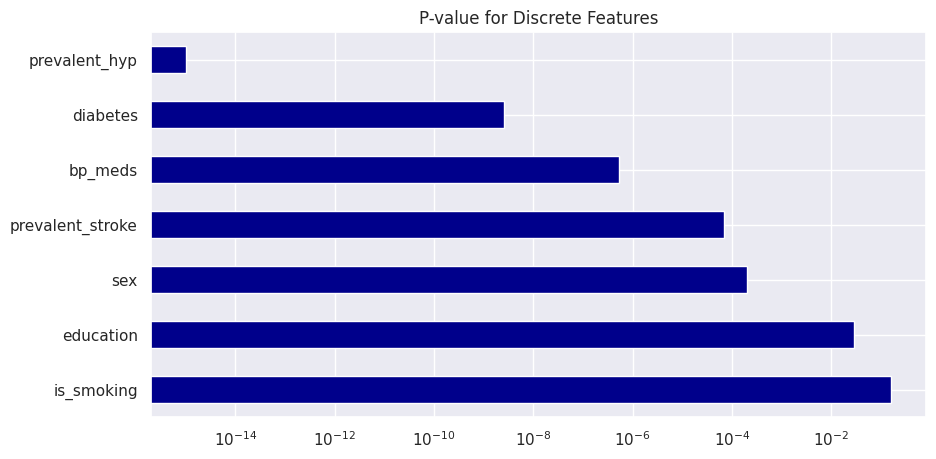

In [ ]:
# Plotting p values for chi2 test for discrete features

plt.figure(figsize=(10, 5))
plt.xscale('log')
plt.xlabel('P-value')
plt.title('P-value for Discrete Features')
p_values.plot.barh(color='darkblue')
plt.show()


The feature "is_smoking" exhibits the highest p-value, suggesting its lower significance among categorical independent variables-> dropped

In [31]:
# dropping is_smoking
df.drop('is_smoking',axis=1,inplace=True)
df_cat.drop('is_smoking',axis=1,inplace=True)

## Log-transformation to come closer to a normal distribution of continuous data

In [ ]:
# skewness along the index axis
(df[cont_var]).skew(axis = 0)

age                  0.225796
cigs_per_day         1.204077
total_cholesterol    0.948170
bmi                  1.025551
heart_rate           0.676660
glucose              6.361911
pulse_pressure       1.412382
dtype: float64

In [ ]:
# Skew for log10 transformation
np.log10(df[cont_var]+1).skew(axis = 0)

age                 -0.015053
cigs_per_day         0.275072
total_cholesterol    0.011860
bmi                  0.370422
heart_rate           0.165898
glucose              2.310918
pulse_pressure       0.354174
dtype: float64

clearly reduces skewness

In [32]:
# Implementing log transformation on continuous variables
for var in cont_var:
    df[var] = np.log10(df[var].replace(0, 1) + 1)


In [35]:
# save the preprocessed data in google drive
file_name = 'preprocessed_data_chd.csv'
file_path = f'/content/drive/My Drive/heart_disease/data/{file_name}'

# Save the DataFrame to CSV in Google Drive
df.to_csv(file_path, index=False)